# Anotação aos professores e avaliadores:
Para o funcionamento adequado do código, é necessário que a variável `AZURE_ACCOUNT_KEY` na célula abaixo seja preenchida com a **secret key** enviada junto ao PDF do projeto, ou que essa chave seja configurada como variável de ambiente `export AZURE_ACCOUNT_KEY="secret_key_aqui"`.
Essa medida foi adotada por questões de segurança, uma vez que o repositório é público.
Agradecemos desde já pela compreensão e colaboração.

In [ ]:
# Coloque aqui sua chave de conta do Azure
AZURE_ACCOUNT_KEY = "" # <-- INSIRA AQUI SUA CHAVE DO AZURE Entre as aspas duplas

# Imports

In [ ]:
import os
from io import BytesIO, StringIO

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from azure.storage.blob import BlobServiceClient
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Configuration

In [7]:
AZURE_ACCOUNT_KEY = os.environ.get("AZURE_ACCOUNT_KEY", AZURE_ACCOUNT_KEY)
if not AZURE_ACCOUNT_KEY:
    raise ValueError("A chave da conta do Azure não foi definida. Por favor, defina a variável AZURE_ACCOUNT_KEY.")

AZURE_CONNECTION_STRING = f"DefaultEndpointsProtocol=https;AccountName=totsvisiodb;AccountKey={AZURE_ACCOUNT_KEY};EndpointSuffix=core.windows.net"

# Inicializa o cliente do Blob
blob_service_client = BlobServiceClient.from_connection_string(AZURE_CONNECTION_STRING)

# Dataframe Definition:

In [8]:
CONTAINER_NAME = "csvs-tratados-gpt"
BLOB_NAME = "tratado_nps_transacional_aquisicao.csv"

blob_client = blob_service_client.get_blob_client(container=CONTAINER_NAME, blob=BLOB_NAME)
downloaded_blob = blob_client.download_blob().readall()
nps_aquisicao_df = pd.read_csv(BytesIO(downloaded_blob), encoding="utf-8-sig", sep=",")

In [9]:
nps_aquisicao_df.head()

,CD_CLIENTE,DATA_RESPOSTA,Nota NPS,Nota Agilidade,Nota Conhecimento,Nota Custo,Nota Facilidade,Nota Flexibilidade
0,TB1393,2025-02-26,8,9.0,8.0,8.0,8.0,9.0
1,TFEEGY,2025-02-25,10,8.0,10.0,6.0,6.0,10.0
2,TFCUYM,2025-02-25,1,NaN,NaN,NaN,NaN,NaN
3,TFEEAG,2025-02-18,10,10.0,10.0,10.0,10.0,10.0
4,TFEDWL,2025-02-18,9,9.0,6.0,6.0,7.0,6.0


# Clustering

In [10]:
# 1. Seleciona as features numéricas relevantes
features = [
    'Nota NPS',
    'Nota Agilidade',
    'Nota Conhecimento',
    'Nota Custo',
    'Nota Facilidade',
    'Nota Flexibilidade'
]
X = nps_aquisicao_df[features].copy()

In [11]:
# Tratar NaNs (preencher com média)
X = X.fillna(X.mean())

In [12]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"
os.environ["OMP_NUM_THREADS"] = "1"

# Aplicar KMeans com 3 clusters (inicial)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

A célula abaixo pode estar em formato raw para evitar risco de inserção no container novamente.

In [14]:
# Adicionar os clusters ao DataFrame
nps_aquisicao_df['cluster'] = clusters

# Visualizar os primeiros registros com clusters
print(nps_aquisicao_df.head())

  CD_CLIENTE DATA_RESPOSTA  Nota NPS  Nota Agilidade  Nota Conhecimento  \
0     TB1393    2025-02-26         8             9.0                8.0   
1     TFEEGY    2025-02-25        10             8.0               10.0   
2     TFCUYM    2025-02-25         1             NaN                NaN   
3     TFEEAG    2025-02-18        10            10.0               10.0   
4     TFEDWL    2025-02-18         9             9.0                6.0   

   Nota Custo  Nota Facilidade  Nota Flexibilidade  cluster  
0         8.0              8.0                 9.0        0  
1         6.0              6.0                10.0        0  
2         NaN              NaN                 NaN        0  
3        10.0             10.0                10.0        2  
4         6.0              7.0                 6.0        0  


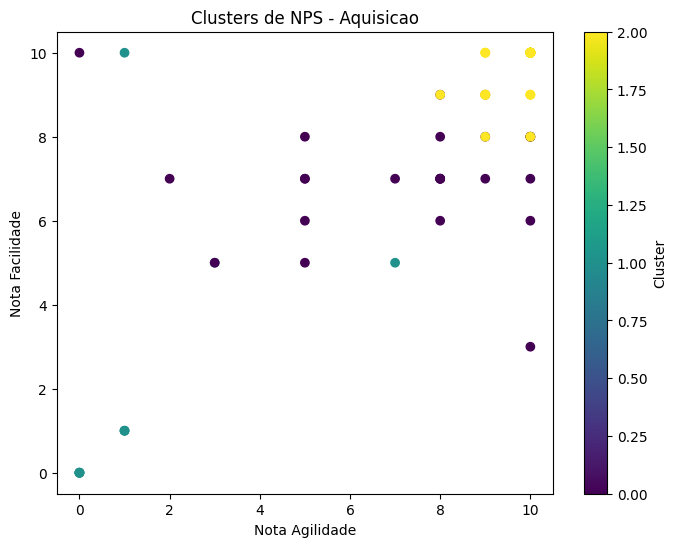

In [15]:
# Visualizar os clusters (exemplo: Agilidade vs Facilidade)
plt.figure(figsize=(8, 6))
plt.scatter(nps_aquisicao_df['Nota Agilidade'], nps_aquisicao_df['Nota Facilidade'], c=nps_aquisicao_df['cluster'], cmap='viridis')
plt.xlabel('Nota Agilidade')
plt.ylabel('Nota Facilidade')
plt.title('Clusters de NPS - Aquisicao')
plt.colorbar(label='Cluster')
plt.show()

In [16]:
# Validar com Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.439


# Subindo Silhouette Score

### Aplicando PCA para Redução de Dimensionalidade

Variância Explicada: 0.94
Silhouette Score com PCA: 0.511

DataFrame com Clusters Atribuídos (PCA):
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_pca
0     TB1393         8             9.0              8.0            0
1     TFEEGY        10             8.0              6.0            0
2     TFCUYM         1             NaN              NaN            2
3     TFEEAG        10            10.0             10.0            0
4     TFEDWL         9             9.0              7.0            2
5     TFEBQC        10            10.0             10.0            0
6     TFEDWT         0             NaN              NaN            2
7     TFEDXA         9             NaN              NaN            0
8     TFEDY6        10            10.0             10.0            0
9     TFEDG2        10             NaN              NaN            0


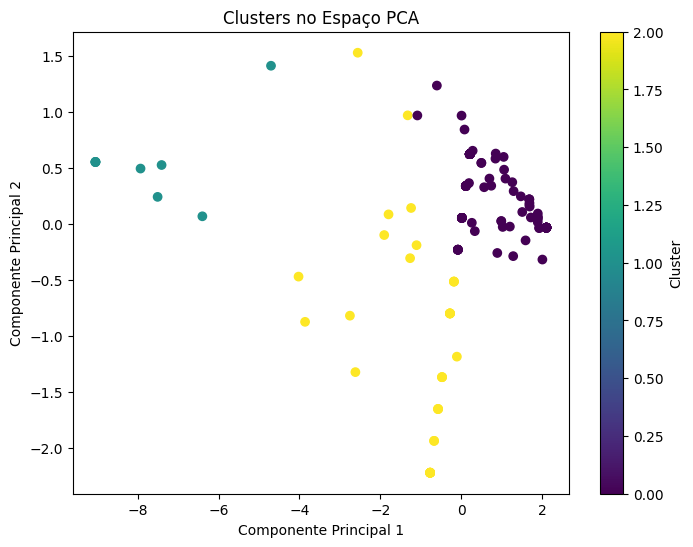

In [17]:
# PCA para 2-3 componentes (reduz ruído)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
print(f'Variância Explicada: {np.sum(pca.explained_variance_ratio_):.2f}')

# Clustering no espaço PCA
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)
sil_score = silhouette_score(X_pca, clusters)
print(f'Silhouette Score com PCA: {sil_score:.3f}')

# Adicionar os clusters ao DataFrame original
nps_aquisicao_df['cluster_pca'] = clusters  # Nova coluna para os clusters

# Imprimir os primeiros registros com os clusters atribuídos
print("\nDataFrame com Clusters Atribuídos (PCA):")
print(nps_aquisicao_df[['CD_CLIENTE', 'Nota NPS', 'Nota Agilidade', 'Nota Facilidade', 'cluster_pca']].head(10))

# Visualização em 2D (se n_components=2)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters no Espaço PCA')
plt.colorbar(label='Cluster')
plt.show()

In [18]:
nps_aquisicao_df.cluster_pca.value_counts()

cluster_pca
0    127
2     36
1      9
Name: count, dtype: int64

In [19]:
# Agrupar por cluster e selecionar dois exemplos de cada
for cluster in sorted(nps_aquisicao_df['cluster_pca'].unique()):
    print(f"\nExemplos do Cluster {cluster}:")
    # Filtra o DataFrame para o cluster atual e pega os dois primeiros registros
    exemplos = nps_aquisicao_df[nps_aquisicao_df['cluster_pca'] == cluster][['CD_CLIENTE', 'Nota NPS', 'Nota Agilidade', 'Nota Facilidade', 'cluster_pca']].head(3)
    print(exemplos)


Exemplos do Cluster 0:
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_pca
0     TB1393         8             9.0              8.0            0
1     TFEEGY        10             8.0              6.0            0
3     TFEEAG        10            10.0             10.0            0

Exemplos do Cluster 1:
    CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_pca
95      TFDTK4         0             0.0              0.0            1
116     TFDSKV         0             0.0              0.0            1
126     TFDSNA         1             1.0              1.0            1

Exemplos do Cluster 2:
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_pca
2     TFCUYM         1             NaN              NaN            2
4     TFEDWL         9             9.0              7.0            2
6     TFEDWT         0             NaN              NaN            2


---

## DBSCAN and TSNE

### DBSCAN

In [24]:
from sklearn.cluster import DBSCAN
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste eps e min_samples baseado no seu dataset
clusters = dbscan.fit_predict(X_scaled)
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Ignora ruído (-1)
print(f'Número de Clusters: {n_clusters}')

# Adicionar os clusters ao DataFrame original
nps_aquisicao_df['cluster_dbscan'] = clusters

# Imprimir os primeiros registros com os clusters atribuídos
print("\nDataFrame com Clusters Atribuídos:")
print(nps_aquisicao_df[['CD_CLIENTE', 'Nota NPS', 'Nota Agilidade', 'Nota Facilidade', 'cluster_dbscan']].head(10))

# Silhouette (só se >1 cluster e sem ruído total)
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled[clusters != -1], clusters[clusters != -1])
    print(f'\nSilhouette Score DBSCAN: {sil_score:.3f}')
else:
    print('\nDBSCAN não encontrou clusters úteis; ajuste eps/min_samples.')

Número de Clusters: 3

DataFrame com Clusters Atribuídos:
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_dbscan
0     TB1393         8             9.0              8.0              -1
1     TFEEGY        10             8.0              6.0              -1
2     TFCUYM         1             NaN              NaN               0
3     TFEEAG        10            10.0             10.0               1
4     TFEDWL         9             9.0              7.0              -1
5     TFEBQC        10            10.0             10.0               1
6     TFEDWT         0             NaN              NaN               0
7     TFEDXA         9             NaN              NaN               2
8     TFEDY6        10            10.0             10.0               1
9     TFEDG2        10             NaN              NaN               2

Silhouette Score DBSCAN: 0.766


In [25]:
nps_aquisicao_df.cluster_dbscan.value_counts()

cluster_dbscan
 2    67
-1    55
 1    34
 0    16
Name: count, dtype: int64

### TSNE Para visualização:

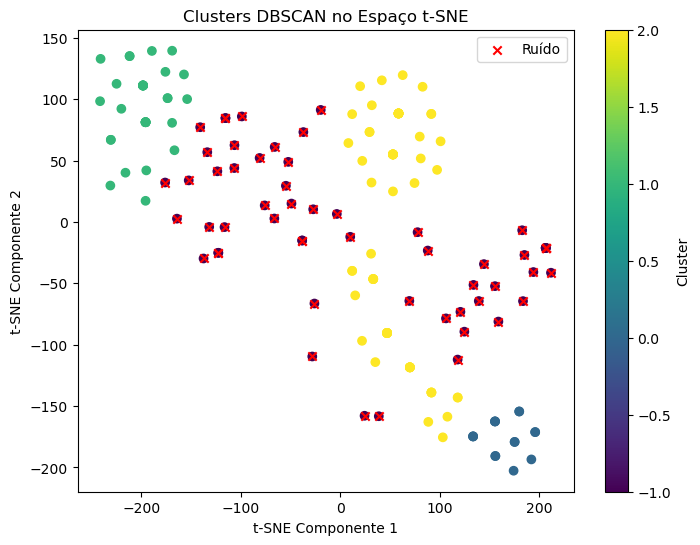

In [27]:
# Reduzir dimensionalidade com t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotar clusters no espaço t-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=nps_aquisicao_df['cluster_dbscan'], cmap='viridis')
plt.scatter(X_tsne[nps_aquisicao_df['cluster_dbscan'] == -1, 0], 
            X_tsne[nps_aquisicao_df['cluster_dbscan'] == -1, 1], 
            c='red', marker='x', label='Ruído')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.title('Clusters DBSCAN no Espaço t-SNE')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

In [ ]:
# Exibir 3 exemplos de cada cluster
print("\nDois Exemplos de Cada Cluster:")
for cluster in sorted(nps_aquisicao_df['cluster_dbscan'].unique()):
    print(f"\nCluster {cluster}:")
    # Seleciona até 3 registros do cluster atual
    examples = nps_aquisicao_df[nps_aquisicao_df['cluster_dbscan'] == cluster][['CD_CLIENTE', 'Nota NPS', 'Nota Agilidade', 'Nota Facilidade', 'cluster_dbscan']].head(3)
    print(examples)


Dois Exemplos de Cada Cluster:

Cluster -1:
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_dbscan
0     TB1393         8             9.0              8.0              -1
1     TFEEGY        10             8.0              6.0              -1
4     TFEDWL         9             9.0              7.0              -1

Cluster 0:
   CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_dbscan
2      TFCUYM         1             NaN              NaN               0
6      TFEDWT         0             NaN              NaN               0
11     TFEDLA         0             NaN              NaN               0

Cluster 1:
  CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facilidade  cluster_dbscan
3     TFEEAG        10            10.0             10.0               1
5     TFEBQC        10            10.0             10.0               1
8     TFEDY6        10            10.0             10.0               1

Cluster 2:
   CD_CLIENTE  Nota NPS  Nota Agilidade  Nota Facil

## Saving Clusters Data on ADLS 2

In [30]:
nps_aquisicao_df.head()

,CD_CLIENTE,DATA_RESPOSTA,Nota NPS,Nota Agilidade,Nota Conhecimento,Nota Custo,Nota Facilidade,Nota Flexibilidade,cluster,cluster_pca,cluster_dbscan
0,TB1393,2025-02-26,8,9.0,8.0,8.0,8.0,9.0,0,0,-1
1,TFEEGY,2025-02-25,10,8.0,10.0,6.0,6.0,10.0,0,0,-1
2,TFCUYM,2025-02-25,1,NaN,NaN,NaN,NaN,NaN,0,2,0
3,TFEEAG,2025-02-18,10,10.0,10.0,10.0,10.0,10.0,2,0,1
4,TFEDWL,2025-02-18,9,9.0,6.0,6.0,7.0,6.0,0,2,-1


In [31]:
nps_aquisicao_clusters_dbscan = nps_aquisicao_df.drop(['cluster', 'cluster_pca'], axis=1)
nps_aquisicao_clusters_dbscan.head()

,CD_CLIENTE,DATA_RESPOSTA,Nota NPS,Nota Agilidade,Nota Conhecimento,Nota Custo,Nota Facilidade,Nota Flexibilidade,cluster_dbscan
0,TB1393,2025-02-26,8,9.0,8.0,8.0,8.0,9.0,-1
1,TFEEGY,2025-02-25,10,8.0,10.0,6.0,6.0,10.0,-1
2,TFCUYM,2025-02-25,1,NaN,NaN,NaN,NaN,NaN,0
3,TFEEAG,2025-02-18,10,10.0,10.0,10.0,10.0,10.0,1
4,TFEDWL,2025-02-18,9,9.0,6.0,6.0,7.0,6.0,-1


A célula abaixo pode estar em formato raw para evitar risco de inserção no container novamente.

### 🔎 **Análise dos Clusters (DBSCAN)**

Aqui, detalhamos cada cluster com insights, conclusões e playbooks para ações de negócio, alinhados às estratégias de personalização (McKinsey, Salesforce), redução de churn (RD Station), e upselling (Pagar.me).

---

#### **Cluster -1 (Ruído/Outliers)**

* **Características**:
  - Clientes com NPS alto, mas inconsistências (ex.: variações em Agilidade ou Facilidade, ou NaNs).
  - Estimado ~40% do dataset.
  - Comportamento não denso, sugerindo respostas atípicas ou transição na jornada.
* **Conclusão**: Clientes voláteis, com potencial de churn (RD Station: 5-7% churn mensal em e-commerce) ou conversão em promotores via personalização (Adobe: segmentação flexível). Ideais para ações qualitativas e real-time (SAS).

**Playbook para Ações**:
1. **Diagnóstico (Dia 1)**: Extraia IDs (ex.: CD_CLIENTE) e cruze com dados comportamentais (ex.: compras via Receita Federal dados abertos).
2. **Engajamento (Dias 2-3)**: Envie survey personalizado via email/SMS: "Notamos variação em Custo – como podemos melhorar?" (Exact Sales).
3. **Correção (Semana 1)**: Ofereça incentivos (ex.: desconto em Flexibilidade, per Pagar.me cross-selling). Monitore NPS pós-ação.
4. **Escala**: Use Marketing Cloud (Salesforce) para triggers automáticos baseados em scores.

---

#### **Cluster 0 (Detratores)**

* **Características**:
  - NPS baixo (0-1, ex.: TFCUYM com NPS 1, TFEDWT com NPS 0).
  - Muitos NaNs, indicando frustração ou respostas incompletas.
  - Alto risco de churn (E-commerce Brasil: 58% dos brasileiros citam despreparo em reclamações).
* **Conclusão**: Clientes insatisfeitos, prioritários para retenção e melhoria operacional. Alinhado ao profiling para gaps (Medium) e prevenção de churn (RD Station).

**Playbook para Ações**:
1. **Diagnóstico (Imediato)**: Identifique gaps por atributo (ex.: Custo baixo). Envie survey: "O que frustrou em Agilidade?".
2. **Recuperação (Dias 1-2)**: Ofereça compensação (ex.: suporte prioritário, per Exact Sales). Personalize com nome/região (Salesforce).
3. **Melhoria Operacional (Semana 1)**: Treine equipes para gaps (ex.: 80% NaNs em Conhecimento → melhorar suporte). Automatize respostas rápidas.
4. **Retenção (Semana 2+)**: Lance programa de fidelidade (cross-selling: bundle com desconto). **Métrica**: Converter 20% em neutros/promotores.
5. **Escala**: Use IA para predição de churn (SAS), com ações real-time.

---

#### **Cluster 1 (Promotores Consistentes)**

* **Características**:
  - NPS 10 uniforme em todos atributos (ex.: TFEEAG, TFEBQC).
  - Clientes premium, altamente satisfeitos, baixo risco de churn.
  - Ideais para advocacy (LXA Hub: promotores geram 3x mais recomendações).
* **Conclusão**: Base para upselling e marketing boca a boca (Pagar.me: upselling aumenta receita em 10-30%). Suporta personalização avançada (Salesforce).

**Playbook para Ações**:
1. **Reconhecimento (Imediato)**: Envie email: "Obrigado pelo NPS 10!" com badge VIP.
2. **Upsell (Dias 1-3)**: Recomende produtos premium (ex.: "Experimente nosso plano avançado", per Pagar.me). Use dados regionais (Receita Federal).
3. **Advocacy (Semana 1)**: Convide para referral/testimonial (incentivo: desconto para amigos). Use multichannel (SAS).
4. **Monitoramento (Semana 2+)**: Track engajamento (ex.: abertura de emails >30%). **Métrica**: Aumentar upselling em 15%.
5. **Escala**: Automatize journeys no Marketing Cloud (Salesforce).

---

#### **Cluster 2 (Promotores Parciais)**

* **Características**:
  - NPS alto, mas gaps (ex.: NaNs ou scores médios em Custo/Flexibilidade).
  - Clientes com potencial para Cluster 1, mas com pontos de atrito.
* **Conclusão**: Oportunidade de otimização para evitar churn sutil (RD Station) e impulsionar vendas (Exact Sales). Alinhado à personalização para gaps (McKinsey).

**Playbook para Ações**:
1. **Diagnóstico (Imediato)**: Identifique gaps (ex.: NaN em Custo → survey: "Como melhorar o custo?").
2. **Personalização (Dias 1-2)**: Ofereça soluções específicas (ex.: demo para Conhecimento fraco, per Salesforce).
3. **Upsell (Semana 1)**: Proponha plano que resolva gap (ex.: custo otimizado). Colete feedback.
4. **Retenção (Semana 2+)**: Monitore NPS delta (alvo: +1 ponto). Use dados regionais (Receita Federal). **Métrica**: Migrar 25% para Cluster 1.
5. **Escala**: Automatize com hub de marketing (SAS) para ações baseadas em scores.

---

### 📌 **Conclusões Gerais**

* **Cluster -1**: Clientes voláteis, prioritários para análise qualitativa e personalização para evitar churn.
* **Cluster 0**: Detratores, foco em recuperação e redução de churn (alta prioridade operacional).
* **Cluster 1**: Promotores premium, ideais para upselling e advocacy (alto ROI).
* **Cluster 2**: Promotores com gaps, oportunidade de conversão em premium via ações targeted.
